Script Name: FSZ_Hub

Author: Fatemeh Delavari  
Version: 2.0 (11/30/2024)  
Description: Analyzes how changes in seizure-related brain connectivity influence variations in node centrality and the formation of hubs and clusters within the brain network.

In [51]:
# Import necessary libraries
import mne
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import pickle 
import networkx as nx
from sklearn.cluster import SpectralClustering

In [52]:
# Define constants
electrodes = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']

In [53]:
# Function for calculating moving average
def moving_average(data, window_size):
    """
    Calculate the moving average of a 1D array.

    Parameters:
    data (list or np.ndarray): Input data array.
    window_size (int): The size of the moving window.

    Returns:
    np.ndarray: The moving average of the input data.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Window size must not exceed the length of the data.")

    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

In [54]:
# Function for normalizing a matrix
def normalize_matrix(matrix):
    """
    Normalizes the values in a matrix (nested list) to a range between 0 and 1.
    
    Parameters:
    matrix (list of lists): Input matrix to be normalized.

    Returns:
    list of lists: Normalized matrix.
    """
    # Flatten the matrix to find the global min and max values
    flat_matrix = [item for row in matrix for item in row]
    min_val = min(flat_matrix)
    max_val = max(flat_matrix)

    # Avoid division by zero if all elements are the same
    if max_val == min_val:
        return [[0.5 for _ in row] for row in matrix]

    # Normalize each element in the matrix
    normalized_matrix = [
        [(value - min_val) / (max_val - min_val) for value in row]
        for row in matrix
    ]

    return normalized_matrix

In [55]:
# Function to extract focal channels
def extract_fnsz_channels(file_path):
    """
    Extract channel names corresponding to rows with the label 'fnsz' for each start time,
    merging start times that are 5 seconds or less apart into the earliest start time.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        dict: A dictionary where keys are start times and values are lists of channel names.
    """
    try:
        # Load CSV data, skipping lines that start with '#'
        data = pd.read_csv(file_path, comment='#')
        
        # Filter rows with the label 'fnsz'
        fnsz_data = data[data['label'] == 'fnsz']
        
        # Helper function to convert differential montage channels to detailed channel names
        def convert_channel_to_detailed(channel):
            return channel.split('-')  # Split into parts for detailed representation
        
        # Sort start times and merge them if they are within 5 seconds
        sorted_times = sorted(fnsz_data['start_time'].unique())
        merged_start_times = []
        current_group = [sorted_times[0]]

        for i in range(1, len(sorted_times)):
            if sorted_times[i] - current_group[-1] <= 5:
                current_group.append(sorted_times[i])
            else:
                merged_start_times.append(current_group)
                current_group = [sorted_times[i]]
        merged_start_times.append(current_group)  # Add the last group
        
        # Create a mapping from each original start time to its merged start time
        start_time_mapping = {
            time: group[0] for group in merged_start_times for time in group
        }
        
        # Map each start time to the merged time
        fnsz_data['merged_start_time'] = fnsz_data['start_time'].map(start_time_mapping)
        
        # Group by 'merged_start_time' and extract unique, detailed channels for each group
        focal_zone_channels = (
            fnsz_data.groupby('merged_start_time')['channel']
            .apply(lambda channels: list(
                set(
                    detailed_channel
                    for ch in channels.unique()
                    for detailed_channel in convert_channel_to_detailed(ch)
                ) & set(electrodes)  # Filter channels based on the predefined 'electrodes' set
            ))
            .to_dict()
        )
        
        return focal_zone_channels

    except Exception as e:
        print(f"Error processing file '{file_path}': {e}")
        return {}

In [ ]:
# Load the saved data
with open("epgb_1t3760.pkl", "rb") as f: # 0 to 111
    loaded_data = pickle.load(f)
all_data = loaded_data 

In [ ]:
# Specify the folder path containing the EDF files
folder_path = 'C:/Users/Atena/Documents/edf'
# Specify the folder path containing the CSV files
folder_path_csv = 'C:/Users/Atena/Documents/csv'

In [ ]:
# # I had To this step by step due to computational cost!

# # Load the saved data
# with open("epgb_0t110.pkl", "rb") as f: # 0 to 111
#     loaded_data = pickle.load(f)
# all_data1 = loaded_data 

# with open("epgb_112t232.pkl", "rb") as f: # 112 to 232
#     loaded_data = pickle.load(f)
# all_data2 = loaded_data   

# with open("epgb_233t325.pkl", "rb") as f: # 233 to 325
#     loaded_data = pickle.load(f)
# all_data3 = loaded_data   

# with open("epgb_346t455.pkl", "rb") as f: # 346 to 455
#     loaded_data = pickle.load(f)
# all_data4 = loaded_data

# with open("epgb_456t570.pkl", "rb") as f: # 456 to 570
#     loaded_data = pickle.load(f)
# all_data5 = loaded_data   

# with open("epgb_571t760.pkl", "rb") as f: # 571 to 760
#     loaded_data = pickle.load(f)
# all_data6 = loaded_data    

# with open("epgb_761t975.pkl", "rb") as f: # 761 to 975
#     loaded_data = pickle.load(f)
# all_data7 = loaded_data 

# with open("epgb_976t1250.pkl", "rb") as f: # 976 to 1250
#     loaded_data = pickle.load(f)
# all_data8 = loaded_data   

# with open("epgb_1251t1386.pkl", "rb") as f: # 1251 to 1386
#     loaded_data = pickle.load(f)
# all_data9 = loaded_data   

# with open("epgb_1388t2018.pkl", "rb") as f: # 1389 to 2018
#     loaded_data = pickle.load(f)
# all_data10 = loaded_data   

# with open("epgb_2019t2822.pkl", "rb") as f: # 2019 to 2822
#     loaded_data = pickle.load(f)
# all_data11 = loaded_data  

# with open("epgb_2823t3764.pkl", "rb") as f: # 2823 to 3763
#     loaded_data = pickle.load(f)
# all_data12 = loaded_data   

# all_data2 = {key+112: value for key, value in all_data2.items()}
# all_data3 = {key+233: value for key, value in all_data3.items()}
# all_data4 = {key+346: value for key, value in all_data4.items()}
# all_data5 = {key+456: value for key, value in all_data5.items()}
# all_data6 = {key+571: value for key, value in all_data6.items()}
# all_data7 = {key+761: value for key, value in all_data7.items()}
# all_data8 = {key+976: value for key, value in all_data8.items()}
# all_data9 = {key+1251: value for key, value in all_data9.items()}
# all_data10 = {key+1389: value for key, value in all_data10.items()}
# all_data11 = {key+2019: value for key, value in all_data11.items()}
# all_data12 = {key+2823: value for key, value in all_data12.items()}
# all_data = all_data1 | all_data2 | all_data3 | all_data4 |all_data5 | all_data6 |all_data7 | all_data8 |all_data9 | all_data10 |all_data11 | all_data12

# # Specify the folder path containing the EDF files
# folder_path = 'C:/Users/Atena/Documents/edf_0t3763'
# # Specify the folder path containing the CSV files
# folder_path_csv = 'C:/Users/Atena/Documents/csv_0t3763'

In [57]:
# Extract focal channels in all seizures in all recordings
target_labels = ['fnsz']
FOZ = {}
file_num = -1
# Loop through all the EDF files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.edf'):  # Check if the file is an EDF file
        file_num = file_num + 1

        # Strip the .edf extension and look for the corresponding .csv file
        base_name = os.path.splitext(file_name)[0]
        csv_file_name = base_name + '.csv'
                
        # Check if the corresponding CSV file exists
        if csv_file_name in os.listdir(folder_path_csv):
            csv_file_path = os.path.join(folder_path_csv, csv_file_name)
            # Read the CSV file
            df = pd.read_csv(csv_file_path, comment='#') 

            # Extract the unique labels from the 'label' column, ignoring case sensitivity
            unique_labels = df['label'].str.lower().unique()

            # Find matching labels (case-insensitive comparison)
            matching_labels = [label for label in unique_labels if label in target_labels]

            # Convert the label column to lowercase for case-insensitive matching
            df['label'] = df['label'].str.lower()

            # Filter the rows that match the target labels
            matching_df = df[df['label'].isin(target_labels)]

            # Check if any label contains 'sz'
            if any('fnsz' in label for label in unique_labels):
                channels = extract_fnsz_channels(csv_file_path)
                FOZ[file_num] = channels


C:\Users\Atena\AppData\Local\Temp\ipykernel_2888\4259460253.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fnsz_data['merged_start_time'] = fnsz_data['start_time'].map(start_time_mapping)
C:\Users\Atena\AppData\Local\Temp\ipykernel_2888\4259460253.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fnsz_data['merged_start_time'] = fnsz_data['start_time'].map(start_time_mapping)
C:\Users\Atena\AppData\Local\Temp\ipykernel_2888\4259460253.py:43: SettingWithCopyWarning: 
A value is trying to be set on a

In [58]:
FOZ

{22: {86.0306: ['F7', 'T3', 'T5']},
 54: {9.048: ['T4', 'O2', 'T6', 'P4', 'FP2', 'F8', 'C4']},
 57: {685.356: ['T3', 'F4', 'T4', 'C3', 'FP2', 'O1', 'T5'],
  715.0055: ['F4', 'T4', 'FP2', 'F8', 'C4'],
  965.232: ['F4', 'T4', 'FP2', 'O1', 'T5'],
  985.9: ['T4', 'FP1', 'F3', 'FP2', 'F8'],
  1005.564: ['T3', 'T5']},
 61: {39.844: ['F4', 'T4', 'O2', 'P4', 'FP2', 'F8']},
 62: {26.528: ['F4', 'T4', 'O2', 'P4', 'FP2', 'F8']},
 64: {20.96: ['T3', 'F4', 'T4', 'CZ', 'C3', 'O2', 'P4', 'FP2', 'C4'],
  36.96: ['F8', 'FP2'],
  533.204: ['P4', 'O2'],
  561.272: ['O2', 'T6'],
  1051.924: ['T3', 'C3', 'O2', 'FP1', 'F7', 'P4']},
 71: {42.2786: ['T3',
   'T4',
   'CZ',
   'C3',
   'O2',
   'FP1',
   'P4',
   'F3',
   'O1',
   'P3',
   'C4',
   'T5'],
  133.804: ['T3',
   'T4',
   'CZ',
   'C3',
   'O2',
   'FP1',
   'P4',
   'F3',
   'O1',
   'P3',
   'C4',
   'T5'],
  222.636: ['T3',
   'T4',
   'CZ',
   'C3',
   'O2',
   'FP1',
   'P4',
   'F3',
   'O1',
   'P3',
   'C4',
   'T5'],
  291.424: ['T3',
   

In [59]:
# Calculate number of recordings and subjects with focal non-specific seizure
num_recordings = len(all_data.keys()) # number of recordings in the dataset
print(f'Number of recordings: {num_recordings}')   

# Retreive Recording name 
RecNam ={}
target_labels = ['fnsz']
file_num = -1
# Loop through all the EDF files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.edf'):  # Check if the file is an EDF file
        file_num = file_num + 1

        # Strip the .edf extension and look for the corresponding .csv file
        base_name = os.path.splitext(file_name)[0]
        csv_file_name = base_name + '.csv'
                
        # Check if the corresponding CSV file exists
        if csv_file_name in os.listdir(folder_path_csv):
            csv_file_path = os.path.join(folder_path_csv, csv_file_name)
            # Read the CSV file
            df = pd.read_csv(csv_file_path, comment='#') 

            # Extract the unique labels from the 'label' column, ignoring case sensitivity
            unique_labels = df['label'].str.lower().unique()

            # Find matching labels (case-insensitive comparison)
            matching_labels = [label for label in unique_labels if label in target_labels]

            # Convert the label column to lowercase for case-insensitive matching
            df['label'] = df['label'].str.lower()

            # Filter the rows that match the target labels
            matching_df = df[df['label'].isin(target_labels)]

            # Check if any label contains 'sz'
            if any('fnsz' in label for label in unique_labels):   
                RecNam[file_num]= file_name   

RecordingsNames = [value[:8] for value in RecNam.values()]
SubjectsName = list(set(RecordingsNames))
print(SubjectsName)
NumSubjects = len(SubjectsName)
print(f'Number of subjects: {NumSubjects}')  

NumSeiz = 0
for file_num in all_data.keys():
    ROIs = all_data[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())

    for seiz_num in range(len(ROI_list)):
        NumSeiz+=1
print(f'Number of seizures: {seiz_num}')  

Number of recordings: 368
['aaaaaoqf', 'aaaaaooo', 'aaaaafjw', 'aaaaakog', 'aaaaaguu', 'aaaaajnw', 'aaaaafoq', 'aaaaakkm', 'aaaaaalq', 'aaaaaplb', 'aaaaaasf', 'aaaaaiat', 'aaaaakqu', 'aaaaapks', 'aaaaaedy', 'aaaaabom', 'aaaaapnl', 'aaaaalpj', 'aaaaadsz', 'aaaaalnx', 'aaaaagtt', 'aaaaagpk', 'aaaaaogd', 'aaaaaauj', 'aaaaanrb', 'aaaaaqbb', 'aaaaabms', 'aaaaaltw', 'aaaaalnt', 'aaaaaksg', 'aaaaankc', 'aaaaajqo', 'aaaaappt', 'aaaaafzt', 'aaaaaogk', 'aaaaabyy', 'aaaaajat', 'aaaaacsx', 'aaaaaosc', 'aaaaaead', 'aaaaagoo', 'aaaaanme', 'aaaaalpn', 'aaaaaetk', 'aaaaajkh', 'aaaaaksh', 'aaaaafxr', 'aaaaaelb', 'aaaaadqb', 'aaaaacwu', 'aaaaabln', 'aaaaaawc', 'aaaaaexr', 'aaaaaias', 'aaaaamqy', 'aaaaajfq', 'aaaaajrj', 'aaaaajgl', 'aaaaahxq', 'aaaaalfs', 'aaaaamww', 'aaaaabqy', 'aaaaajdn', 'aaaaakoe', 'aaaaaqkb', 'aaaaaakv', 'aaaaahof', 'aaaaakmu', 'aaaaadro', 'aaaaapmd', 'aaaaafav', 'aaaaabnn', 'aaaaaiui', 'aaaaajns', 'aaaaalhf', 'aaaaamhb', 'aaaaanmh', 'aaaaakbz', 'aaaaadao', 'aaaaagqb', 'aaaaalwv', '

In [60]:
# make sure that the keys of graph data and focal channels are the same
nFOZ = dict(zip(all_data.keys(), FOZ.values()))

In [61]:
# Function to organize the centrality of nodes in different graphs so that they are given in the same order and a value is assigned to all of the nodes 
def sort_dict_by_list_order(dictionary, order_list):
    """
    Sorts a dictionary by the order of keys in a list. Missing keys are assigned a value of zero.
    
    :param dictionary: The dictionary to sort.
    :param order_list: The list defining the order of keys.
    :return: A sorted dictionary with missing keys assigned a value of zero.
    """
    sorted_dict = {key: dictionary.get(key, 0) for key in order_list}
    return sorted_dict

In [ ]:
# Calculate and normalize degree centrality of all nodes in all graphs in all seizures in all recordings 
CentralityElectrodesD = {}
for file_num in nFOZ.keys():
# all_data.keys():
    CentralityElectrodesD[file_num] = {}
    graphs_bi = all_data[file_num]['graphs_bi']
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())
    for seiz_num in range(0, len(ROI_list)):

        CentralityElectrodesD[file_num][seiz_num] = {}

        cntmat = []
        for i in range(len(graphs_bi)):    
            centrality_s = nx.degree_centrality(graphs_bi[i])
            
            c_centrality_s = {key.replace('-REF', '').replace('-LE', ''): value for key, value in centrality_s.items()}
            order = ['EEG FP1', 'EEG FP2', 'EEG F7', 'EEG F3', 'EEG FZ', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG CZ', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG PZ', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

            c_centrality_sn = sort_dict_by_list_order(c_centrality_s, order)

            cntmat.append(list(c_centrality_sn.values()))

            
        CentralityElectrodesD[file_num][seiz_num] = normalize_matrix(cntmat)

In [63]:
# Calculate and normalize eigenvector centrality of all nodes in all graphs in all seizures in all recordings 
CentralityElectrodesE = {}
for file_num in nFOZ.keys():
# all_data.keys():
    CentralityElectrodesE[file_num] = {}
    graphs_bi = all_data[file_num]['graphs_bi']
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())
    for seiz_num in range(0, len(ROI_list)):

        CentralityElectrodesE[file_num][seiz_num] = {}

        cntmat = []
        for i in range(len(graphs_bi)):    
            centrality_s = nx.eigenvector_centrality(graphs_bi[i], max_iter= 20000)
            
            c_centrality_s = {key.replace('-REF', '').replace('-LE', ''): value for key, value in centrality_s.items()}
            order = ['EEG FP1', 'EEG FP2', 'EEG F7', 'EEG F3', 'EEG FZ', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG CZ', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG PZ', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

            c_centrality_sn = sort_dict_by_list_order(c_centrality_s, order)

            cntmat.append(list(c_centrality_sn.values()))

            
        CentralityElectrodesE[file_num][seiz_num] = normalize_matrix(cntmat)

In [ ]:
# # Calculate and normalize centrality of all nodes in Weighted graphs in all seizures in all recordings 
# CentralityElectrodesW = {}
# for file_num in nFOZ.keys():
# # all_data.keys():
#     CentralityElectrodesW[file_num] = {}
#     graphs = all_data[file_num]['graphs']
#     ROIs = nFOZ[file_num]
#     ROI_list = list(ROIs.values())
#     FOZ_time = list(ROIs.keys())
#     for seiz_num in range(0, len(ROI_list)):

#         CentralityElectrodesW[file_num][seiz_num] = {}

#         cntmat = []
#         for i in range(len(graphs)):    
#             centrality_s = nx.eigenvector_centrality(graphs[i], max_iter= 1000, weight= 'weight')
            
#             # # Calculate degree centrality
#             # centrality_s = {node: sum(data['weight'] for _, _, data in graphs[i].edges(node, data=True)) for node in graphs[i].nodes()}

#             c_centrality_s = {key.replace('-REF', '').replace('-LE', ''): value for key, value in centrality_s.items()}

#             cntmat.append(list(c_centrality_s.values()))
            
#         CentralityElectrodesW[file_num][seiz_num] = normalize_matrix(cntmat)

In [ ]:
# # Calculate  and normalize rank of centrality of all nodes in all graphs in all seizures in all recordings 
# CentralityElectrodesRank = {}
# for file_num in nFOZ.keys():
# # all_data.keys():
#     CentralityElectrodesRank[file_num] = {}
#     graphs = all_data[file_num]['graphs']
#     ROIs = nFOZ[file_num]
#     ROI_list = list(ROIs.values())
#     FOZ_time = list(ROIs.keys())
#     for seiz_num in range(0, len(ROI_list)):

#         CentralityElectrodesRank[file_num][seiz_num] = {}

#         cntmat = []
#         for i in range(len(graphs)):    
#             # centrality_s = nx.eigenvector_centrality(graphs_bi[i], max_iter= 1000)

#             # Calculate weighted degree centrality
#             centrality_s = {node: sum(data['weight'] for _, _, data in graphs[i].edges(node, data=True)) for node in graphs[i].nodes()}

#             c_centrality_s = {key.replace('-REF', '').replace('-LE', ''): value for key, value in centrality_s.items()}

#             # Sorting and ranking
#             sorted_values = sorted(c_centrality_s.values(), reverse=True)  # Sort values in descending order
#             rank_mapping = {value: 19 - rank for rank, value in enumerate(sorted_values)}  # Map values to ranks

#             # Create a new dictionary with the same keys and their corresponding ranks
#             ranked_eeg_values = {key: rank_mapping[value] for key, value in c_centrality_s.items()}

#             cntmat.append(list(ranked_eeg_values.values()))
            
#         CentralityElectrodesRank[file_num][seiz_num] = normalize_matrix(cntmat)

In [65]:
# Calculate and normalize graph density in all graphs in all seizures in all recordings 
Densities = {}
for file_num in nFOZ.keys():
    Densities[file_num] = {}
    graphs_bi = all_data[file_num]['graphs_bi']
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())
    for seiz_num in range(0, len(ROI_list)):

        Densities[file_num][seiz_num] = {}

        dens = []
        for i in range(len(graphs_bi)):    
            density_s = nx.density(graphs_bi[i])

            dens.append(density_s)
            
        Densities[file_num][seiz_num] = (dens - np.min(dens))/(np.max(dens) - np.min(dens))

In [76]:
# Define constants
electrodes = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']

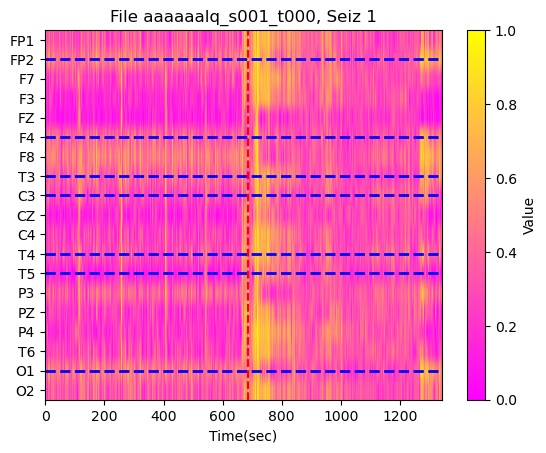

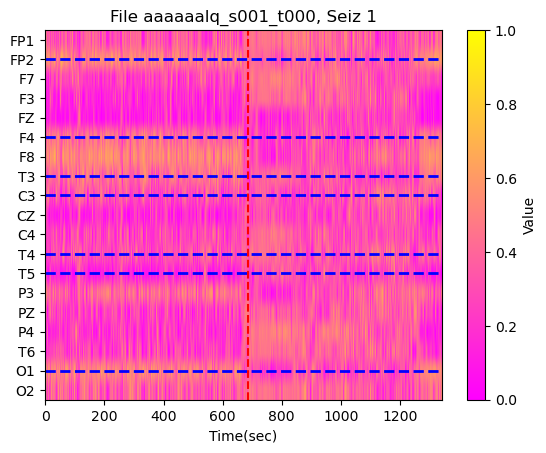

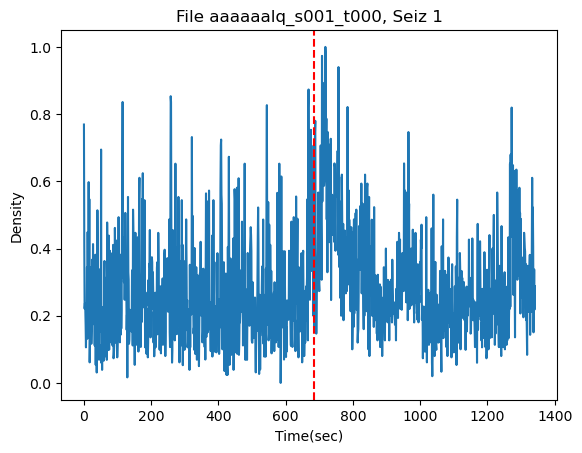

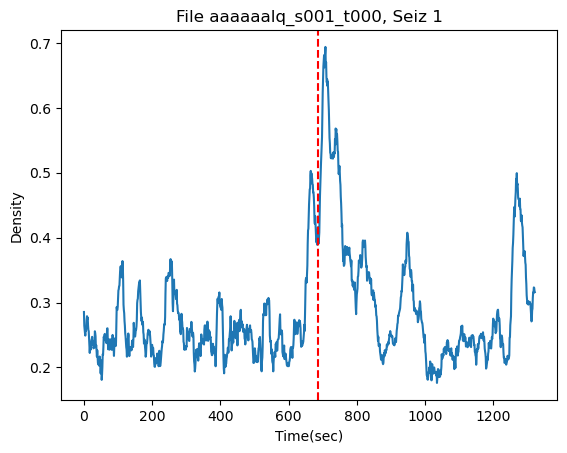

In [77]:
# Visualize the Nodes' Centrality and Density of graphs in an instant seizure
file_num = 57
seiz_num = 0

ROIs = nFOZ[file_num]
ROI_list = list(ROIs.values())
FOZ_time = list(ROIs.keys())
start_point = int(FOZ_time[seiz_num])

plt.imshow((np.array(CentralityElectrodesD[file_num][seiz_num])).T, cmap='spring', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Time(sec)')
# plt.ylabel('Electrode#')
plt.yticks(ticks=np.arange(len(electrodes)), labels=electrodes)
selected_indices = [electrodes.index(el) for el in ROI_list[seiz_num]]
for idx in selected_indices:
        plt.axhline(y=idx, color='b', linestyle='--', linewidth=2)
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.show()

plt.imshow((np.array(CentralityElectrodesE[file_num][seiz_num])).T, cmap='spring', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Time(sec)')
# plt.ylabel('Electrode#')
plt.yticks(ticks=np.arange(len(electrodes)), labels=electrodes)
selected_indices = [electrodes.index(el) for el in ROI_list[seiz_num]]
for idx in selected_indices:
        plt.axhline(y=idx, color='b', linestyle='--', linewidth=2)
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.show()

# plt.imshow((np.array(CentralityElectrodesRank[file_num][seiz_num])).T, cmap='spring', aspect='auto')
# plt.colorbar(label='Value')
# plt.xlabel('Time(sec)')
# # plt.ylabel('Electrode#')
# plt.yticks(ticks=np.arange(len(electrodes)), labels=electrodes)
# selected_indices = [electrodes.index(el) for el in ROI_list[seiz_num]]
# for idx in selected_indices:
#         plt.axhline(y=idx, color='b', linestyle='--', linewidth=2)
# plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
# plt.title(f'File {{RecNam[file_num][:18]}, Seiz {seiz_num+1}')
# plt.show()

plt.plot(Densities[file_num][seiz_num])
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Density')
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.show()

plt.plot(moving_average(Densities[file_num][seiz_num], 20))
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Density')
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.show()

1.2594117148670534


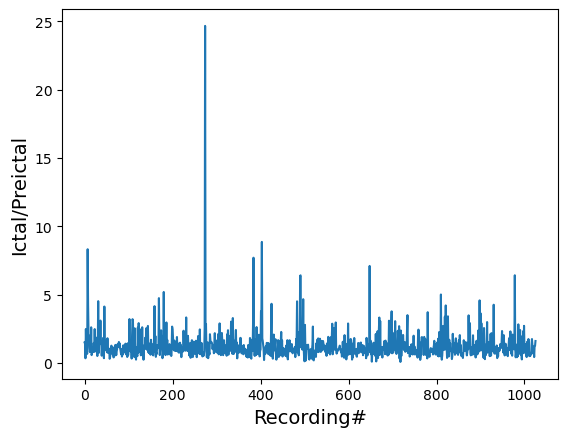

In [180]:
# 
A = 5 # duration considered after seizure onset
B = 15 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

i = -1
Dens_Ratio  = []
for file_num in nFOZ.keys():
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())

    for seiz_num in range(len(ROI_list)):
        start_point = int(FOZ_time[seiz_num])
        seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
        PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
        if (len(PreD)==d & len(seizD)==d):
            DensesR = np.mean(seizD)/np.mean(PreD)
            Dens_Ratio.append(DensesR)

plt.plot(Dens_Ratio)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Ictal/Preictal', fontsize=14)
Gamma = np.mean(Dens_Ratio)
print(Gamma)

Text(0, 0.5, 'Ictal/Preictal')

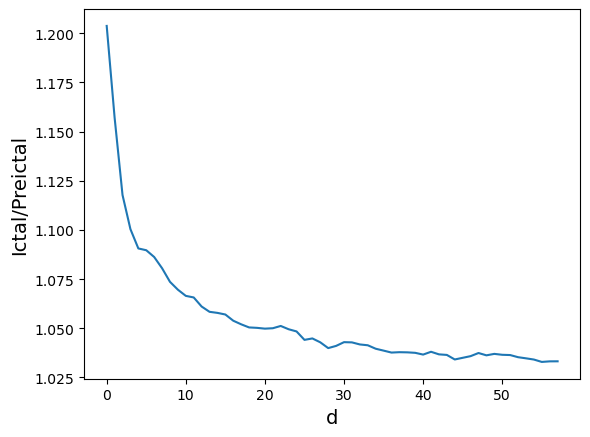

In [344]:
# 
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

Gamma = []
for d in range(2, 60):
    i = -1
    Dens_Ratio  = []
    for file_num in nFOZ.keys():
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            start_point = int(FOZ_time[seiz_num])
            seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
            PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
            if (len(PreD)==d & len(seizD)==d):
                DensesR = np.mean(seizD)/np.mean(PreD)
                Dens_Ratio.append(DensesR)

    Gamma.append(np.mean(Dens_Ratio))

plt.figure()
plt.plot(Gamma)
plt.xlabel('d', fontsize=14)
plt.ylabel('Ictal/Preictal', fontsize=14)

# plt.figure()
# plt.plot(moving_average(Gamma, 20))
# plt.xlabel('d', fontsize=14)
# plt.ylabel('Ictal/Preictal', fontsize=14)


Text(0, 0.5, 'Ictal/Preictal')

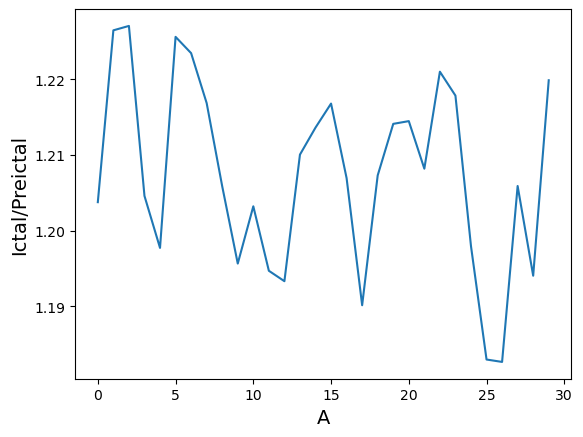

In [345]:
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

Gamma = []
for A in range(0, 30):
    i = -1
    Dens_Ratio  = []
    for file_num in nFOZ.keys():
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            start_point = int(FOZ_time[seiz_num])
            seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
            PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
            if (len(PreD)==d & len(seizD)==d):
                DensesR = np.mean(seizD)/np.mean(PreD)
                Dens_Ratio.append(DensesR)

    Gamma.append(np.mean(Dens_Ratio))

plt.figure()
plt.plot(Gamma)
plt.xlabel('A', fontsize=14)
plt.ylabel('Ictal/Preictal', fontsize=14)

# plt.figure()
# plt.plot(moving_average(Gamma, 20))
# plt.xlabel('A', fontsize=14)
# plt.ylabel('Ictal/Preictal', fontsize=14)

c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Ictal/Preictal')

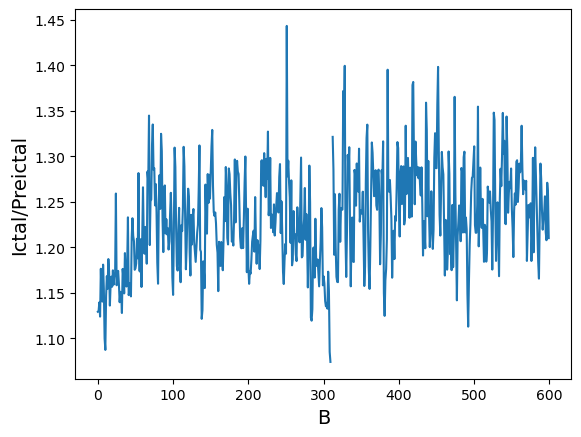

In [346]:
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

Gamma = []
for B in range(0, 600):
    i = -1
    Dens_Ratio  = []
    for file_num in nFOZ.keys():
        ROIs = nFOZ[file_num]

        for seiz_num in range(len(ROI_list)):
            start_point = int(FOZ_time[seiz_num])
            seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
            PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
            if (len(PreD)==d & len(seizD)==d):
                DensesR = np.mean(seizD)/np.mean(PreD)
                Dens_Ratio.append(DensesR)

    Gamma.append(np.mean(Dens_Ratio))

plt.figure()
plt.plot(Gamma)
plt.xlabel('B', fontsize=14)
plt.ylabel('Ictal/Preictal', fontsize=14)

# plt.figure()
# plt.plot(moving_average(Gamma, 20))
# plt.xlabel('B', fontsize=14)
# plt.ylabel('Ictal/Preictal', fontsize=14)

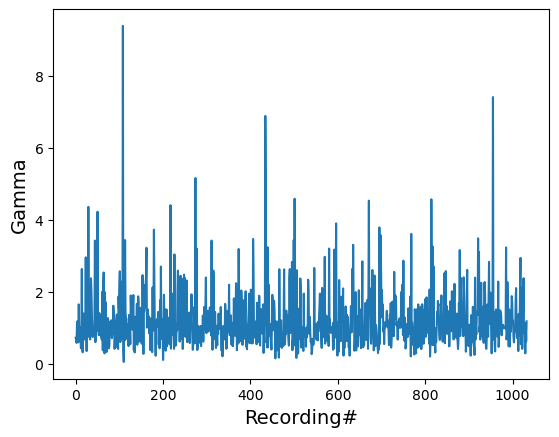

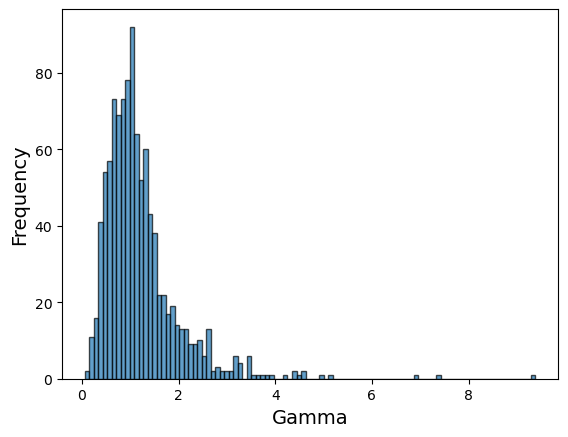

In [349]:
# 
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

Gamma = []
i = -1
Dens_Ratio  = []
for file_num in nFOZ.keys():
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())

    for seiz_num in range(len(ROI_list)):
        start_point = int(FOZ_time[seiz_num])
        seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
        PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
        if (len(PreD)==d & len(seizD)==d):
            DensesR = np.mean(seizD)/np.mean(PreD)
            Dens_Ratio.append(DensesR)

Gamma= Dens_Ratio

plt.figure()
plt.plot(Gamma)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Gamma', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Gamma, bins=100, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()


In [352]:
print(np.mean(Gamma))
print(np.std(Gamma))

1.2037671385740063
0.796583262528868


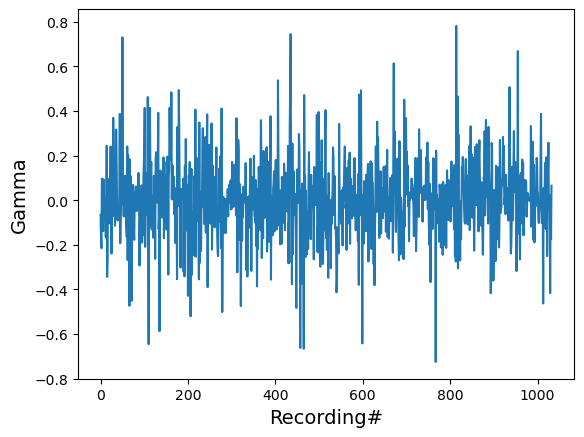

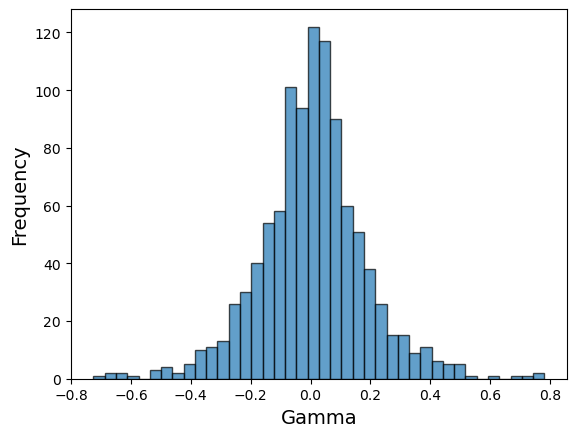

In [318]:
# 
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

Gamma = []
i = -1
Dens_Ratio  = []
for file_num in nFOZ.keys():
    ROIs = nFOZ[file_num]
    ROI_list = list(ROIs.values())
    FOZ_time = list(ROIs.keys())

    for seiz_num in range(len(ROI_list)):
        start_point = int(FOZ_time[seiz_num])
        seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
        PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
        if (len(PreD)==d & len(seizD)==d):
            DensesR = np.mean(seizD)-np.mean(PreD)
            Dens_Ratio.append(DensesR)

Gamma= Dens_Ratio

plt.figure()
plt.plot(Gamma)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Gamma', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Gamma, bins=40, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()


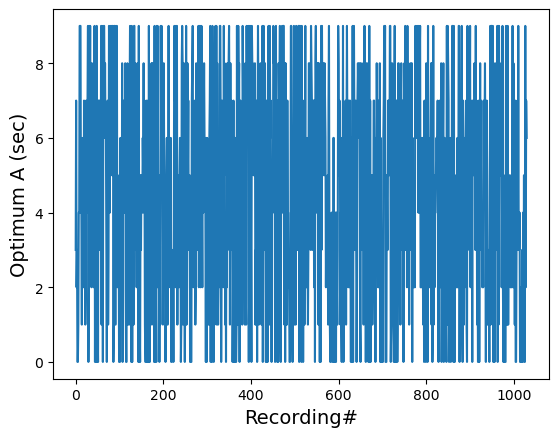

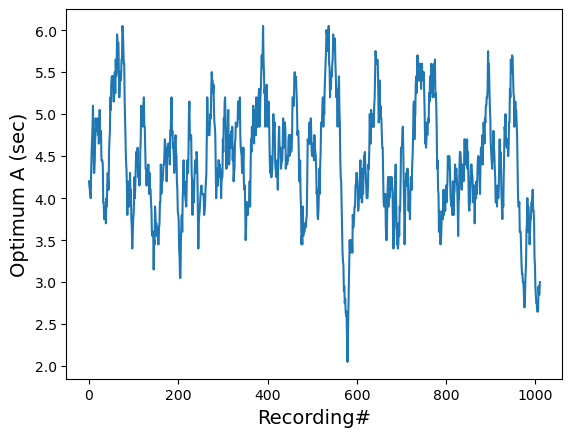

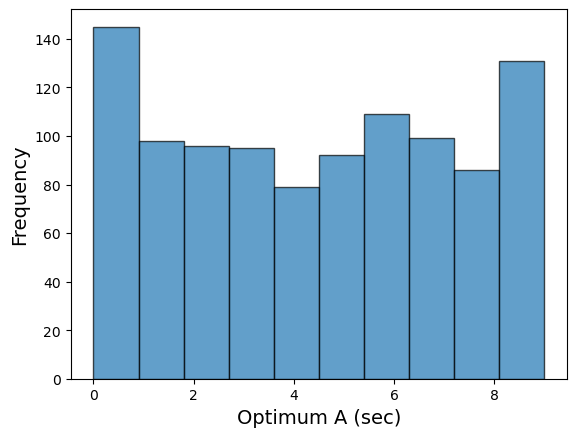

In [253]:
A = 5 # duration considered after seizure onset
B = 15 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_A = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Dens_Ratio  = []
            for A in range(0, 10):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
                PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    DensesR = np.mean(seizD)/np.mean(PreD)
                    Dens_Ratio.append(DensesR)

            Gamma = Dens_Ratio

            if Gamma:
                Opt_A = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_A.append(Opt_A)

plt.figure()
plt.plot(Optim_A)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum A (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_A, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum A (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_A, bins=10, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum A (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()


C:\Users\Atena\AppData\Local\Temp\ipykernel_2888\2136824848.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  DensesR = np.mean(seizD)/np.mean(PreD)


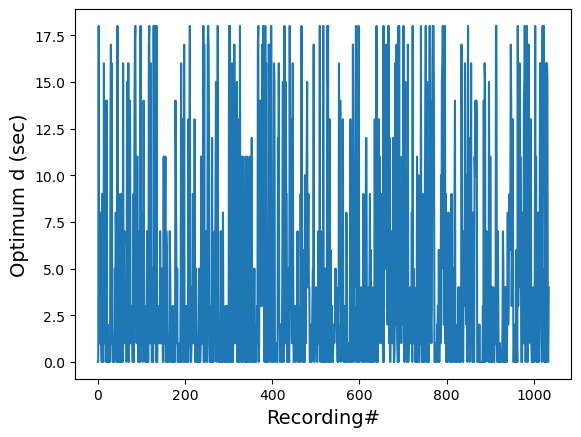

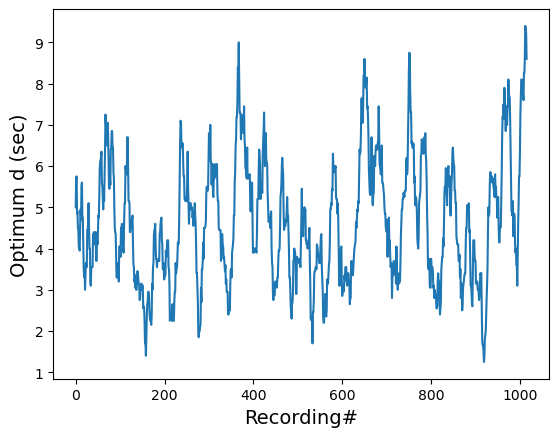

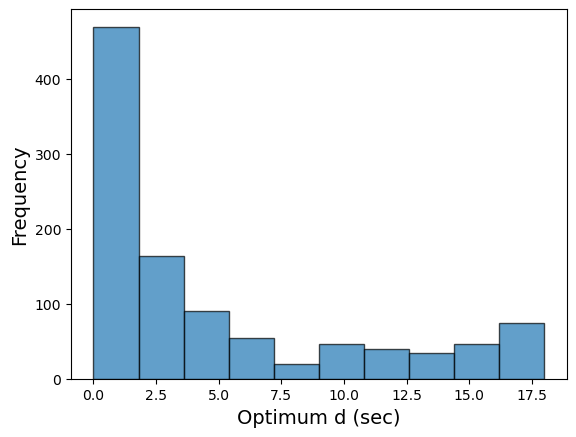

In [254]:
A = 5 # duration considered after seizure onset
B = 15 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_d = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Dens_Ratio  = []
            for d in range(1, 20):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
                PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    DensesR = np.mean(seizD)/np.mean(PreD)
                    Dens_Ratio.append(DensesR)

            Gamma = Dens_Ratio

            if Gamma:
                Opt_d = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_d.append(Opt_d)

plt.figure()
plt.plot(Optim_d)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum d (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_d, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum d (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_d, bins=10, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum d (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

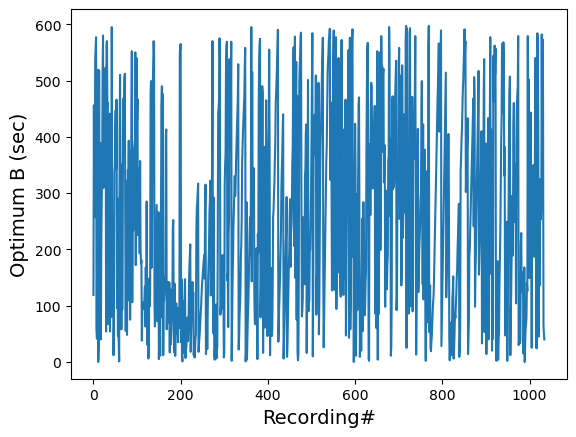

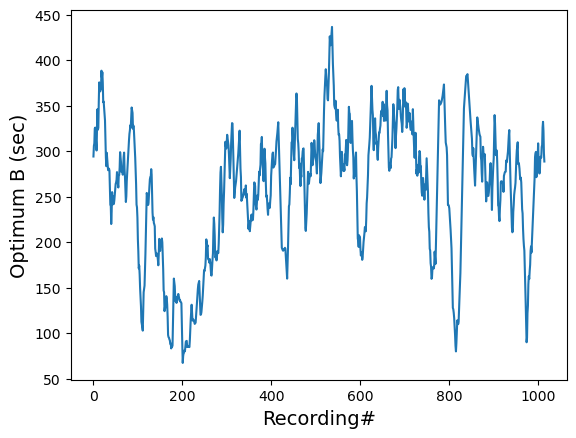

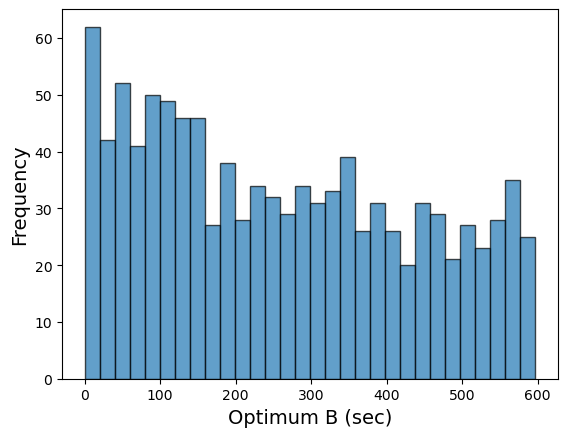

In [258]:
A = 5 # duration considered after seizure onset
B = 15 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_B = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Dens_Ratio  = []
            for B in range(0, 600):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = Densities[file_num][seiz_num][start_point+A:start_point+A+d]
                PreD = Densities[file_num][seiz_num][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    DensesR = np.mean(seizD)/np.mean(PreD)
                    Dens_Ratio.append(DensesR)

            Gamma = Dens_Ratio

            if Gamma:
                Opt_B = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_B.append(Opt_B)

plt.figure()
plt.plot(Optim_B)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum B (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_B, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum B (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_B, bins=30, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum B (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

C:\Users\Atena\AppData\Local\Temp\ipykernel_2888\3579090545.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  CentesR = np.mean(seizD)/np.mean(PreD)


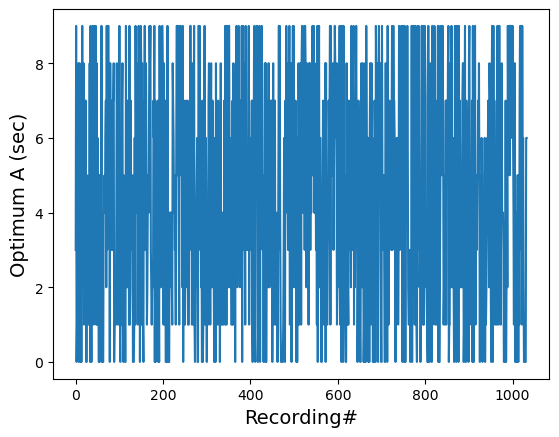

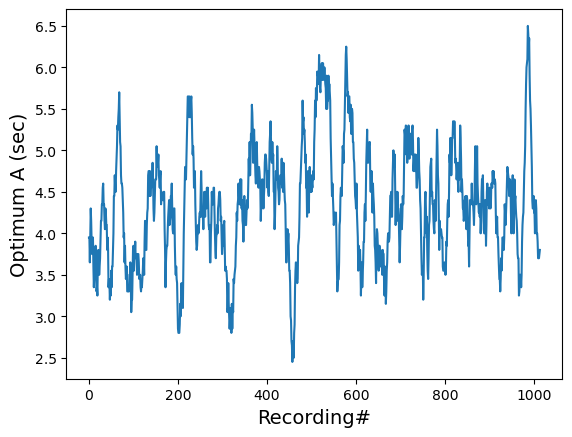

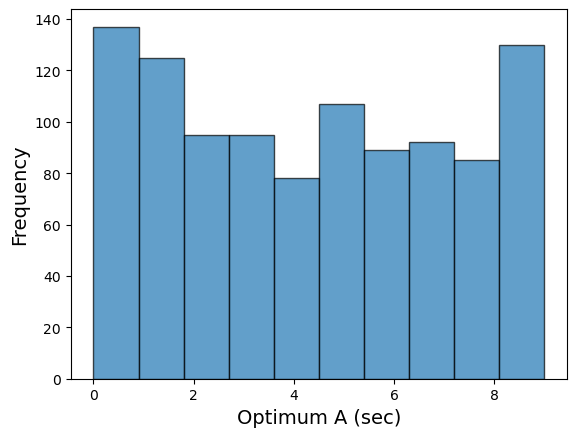

In [286]:
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_A = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Cent_Ratio = []
            for A in range(0, 10):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point+A:start_point+A+d]
                PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    CentesR = np.mean(seizD)/np.mean(PreD)
                    Cent_Ratio.append(CentesR)

            Gamma = Cent_Ratio

            if Gamma:
                Opt_A = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_A.append(Opt_A)

plt.figure()
plt.plot(Optim_A)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum A (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_A, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum A (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_A, bins=10, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum A (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

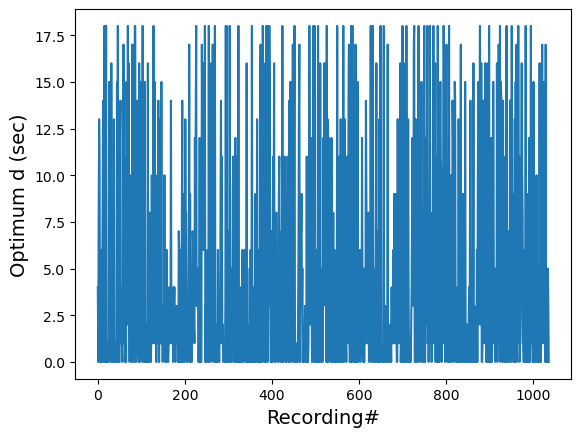

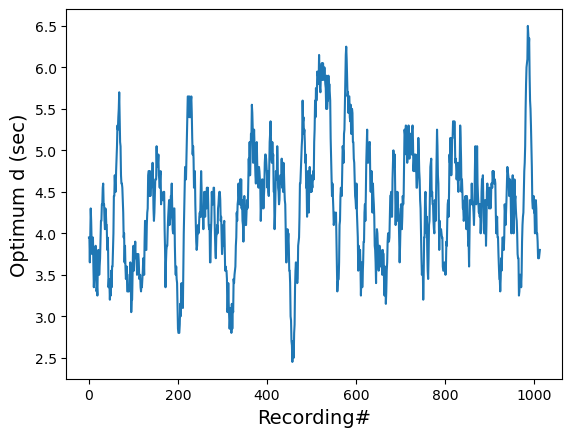

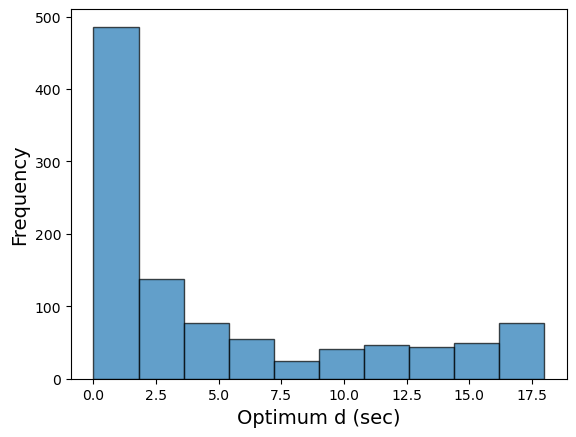

In [322]:
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_d = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Cent_Ratio = []
            for d in range(1, 20):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point+A:start_point+A+d]
                PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    CentesR = np.mean(seizD)/(np.mean(PreD)+0.01)
                    Cent_Ratio.append(CentesR)

            Gamma = Cent_Ratio

            if Gamma:
                Opt_d = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_d.append(Opt_d)

plt.figure()
plt.plot(Optim_d)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum d (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_A, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum d (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_d, bins=10, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum d (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

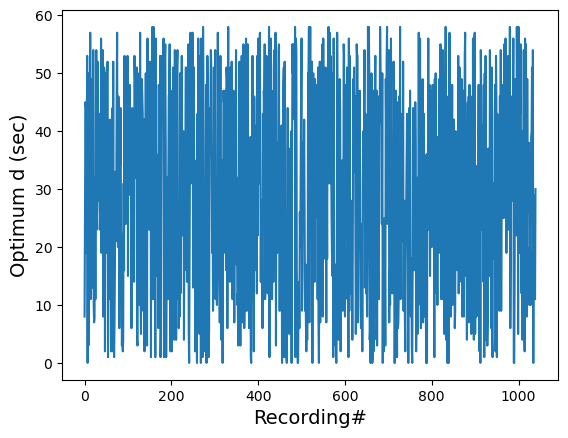

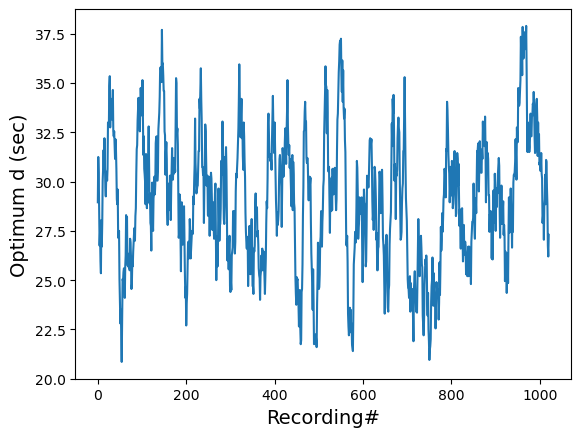

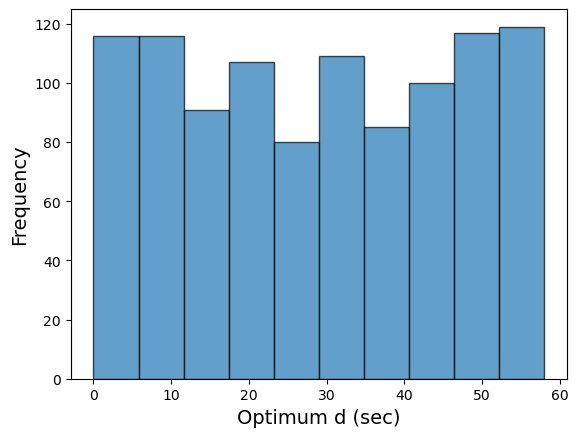

In [ ]:
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

file_num = 57
seiz_num = 0

Optim_B = []

for file_num in nFOZ.keys():
        # print(f'fn: {file_num}')
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            # print(f'sz: {seiz_num}')

            Gamma = []
            Cent_Ratio = []
            for B in range(1, 60):
                i = -1
                
                start_point = int(FOZ_time[seiz_num])
                seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point+A:start_point+A+d]
                PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point-B-d:start_point-B]
                if (len(PreD)==d & len(seizD)==d):
                    CentesR = np.mean(seizD)/(np.mean(PreD)+0.01)
                    Cent_Ratio.append(CentesR)

            Gamma = Cent_Ratio

            if Gamma:
                Opt_B = np.where(Gamma == np.max(Gamma))[0][0]
                # print(f'OptA: {Opt_A}')

                Optim_B.append(Opt_B)

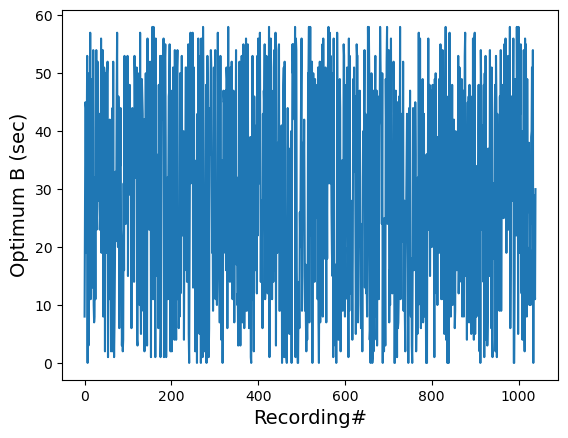

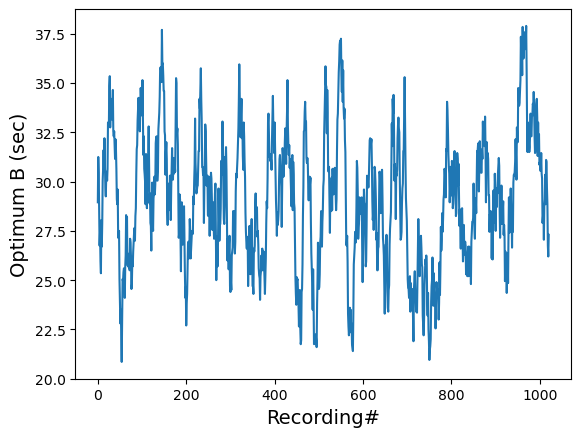

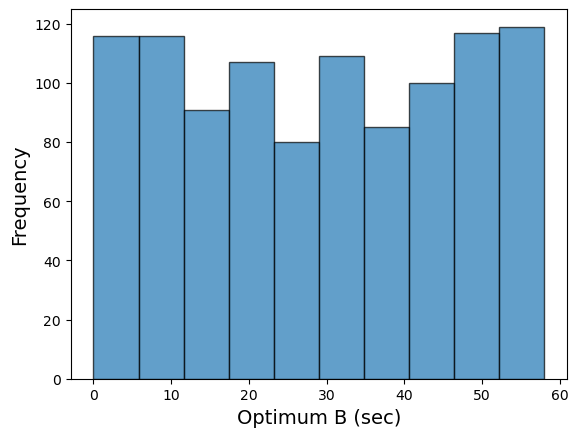

In [ ]:
#
plt.figure()
plt.plot(Optim_B)
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum B (sec)', fontsize=14)

plt.figure()
plt.plot(moving_average(Optim_B, 20))
plt.xlabel('Recording#', fontsize=14)
plt.ylabel('Optimum B (sec)', fontsize=14)

plt.figure()
# Plot the histogram
plt.hist(Optim_B, bins=10, alpha=0.7, edgecolor='black')
# Add titles and labels
plt.xlabel('Optimum B (sec)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

In [ ]:
# 
A = 0 # duration considered after seizure onset
B = 10 # duration considered prior to seizure onset
d = 2 # duration considered for seizure

for chn in range(19):
    Gamma = []
    i = -1
    Cent_Ratio  = []
    for file_num in nFOZ.keys():
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())

        for seiz_num in range(len(ROI_list)):
            start_point = int(FOZ_time[seiz_num])
            seizD = np.array(CentralityElectrodesD[file_num][seiz_num])[:, chn][start_point+A:start_point+A+d]
            PreD = np.array(CentralityElectrodesD[file_num][seiz_num])[:, chn][start_point-B-d:start_point-B]
            if len(PreD)==d and len(seizD)==d:
                CentesR = (np.mean(seizD))-(np.mean(PreD))
                Cent_Ratio.append(CentesR)

    Gamma= Cent_Ratio

    # plt.figure()
    # plt.plot(Gamma)
    # plt.xlabel('Recording#', fontsize=14)
    # plt.ylabel('Gamma', fontsize=14)

    # plt.figure()
    # # Plot the histogram
    # plt.hist(Gamma, bins=40, alpha=0.7, edgecolor='black')
    # # Add titles and labels
    # plt.xlabel('Gamma', fontsize=14)
    # plt.ylabel('Frequency', fontsize=14)
    # # Show the plot
    # plt.show()

-1


In [376]:
# Parameters
A = 0  # Duration considered after seizure onset
B = 10  # Duration considered prior to seizure onset
d = 2  # Duration considered for seizure
Opt_d = 2  # Duration considered for seizure

file_num = 57
seiz_num = 0

Gamma_mat = np.zeros((1000, 19))

# Iterate through 19 channels
for chn in range(19):
    Gamma = []
    i = -1
    Cent_Ratio  = []
    for file_num in nFOZ.keys():
        ROIs = nFOZ[file_num]
        ROI_list = list(ROIs.values())
        FOZ_time = list(ROIs.keys())
        
        for seiz_num in range(len(ROI_list)):
            start_point = int(FOZ_time[seiz_num])

            # Optimize A
            for A in range(10):
                seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point + A : start_point + A + d]
                PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point - B - d : start_point - B]
                if len(PreD) == d and len(seizD) == d:
                    CentesR = np.mean(seizD) - np.mean(PreD)
                    Cent_Ratio.append(CentesR)
            if Cent_Ratio:
                Opt_A = np.argmax(Cent_Ratio)

            # Optimize B
            Cent_Ratio = []
            for B in range(30):
                seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point + Opt_A : start_point + Opt_A + d]
                PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point - B - d : start_point - B]
                if len(PreD) == d and len(seizD) == d:
                    CentesR = np.mean(seizD) - np.mean(PreD)
                    Cent_Ratio.append(CentesR)
            if Cent_Ratio:
                Opt_B = np.argmax(Cent_Ratio)

            # # Optimize d
            # Cent_Ratio = []
            # for d in range(10):
            #     seizD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point + Opt_A : start_point + Opt_A + d]
            #     PreD = np.array(CentralityElectrodesE[file_num][seiz_num])[:, 1][start_point - Opt_B - d : start_point - Opt_B]
            #     if len(PreD) == d and len(seizD) == d:
            #         CentesR = np.mean(seizD) - np.mean(PreD)
            #         Cent_Ratio.append(CentesR)
            # if Cent_Ratio:
            #     Opt_d = np.argmax(Cent_Ratio)

            # Calculate Gamma for the optimal parameters
            seizD = np.array(CentralityElectrodesD[file_num][seiz_num])[:, chn][start_point + Opt_A : start_point + Opt_A + Opt_d]
            PreD = np.array(CentralityElectrodesD[file_num][seiz_num])[:, chn][start_point - Opt_B - Opt_d : start_point - Opt_B]
            if len(PreD) == d and len(seizD) == d:
                CentesR = np.mean(seizD) - np.mean(PreD)
                Gamma.append(CentesR)

    # print(f'{chn}: {Gamma}')
    # dict_Gamma={chn: Gamma}
    Gamma_mat[:, chn] = Gamma


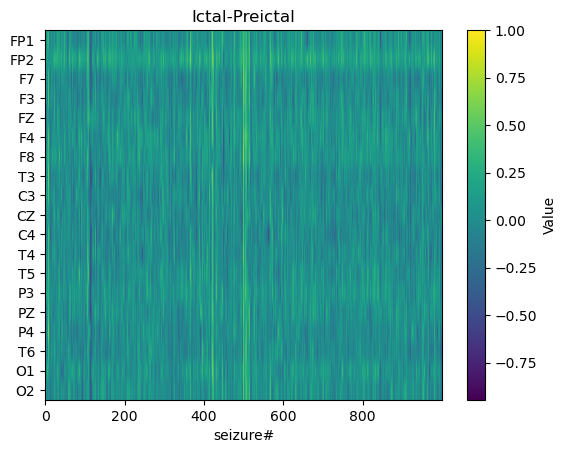

In [393]:
# plt.imshow((Gamma_mat.T), cmap='spring', aspect='auto')
plt.imshow((Gamma_mat.T), aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('seizure#')
# plt.ylabel('Electrode#')
plt.yticks(ticks=np.arange(len(electrodes)), labels=electrodes)
selected_indices = [electrodes.index(el) for el in ROI_list[seiz_num]]
# for idx in selected_indices:
#         plt.axhline(y=idx, color='b', linestyle='--', linewidth=2)
plt.title('Ictal-Preictal')
plt.show()

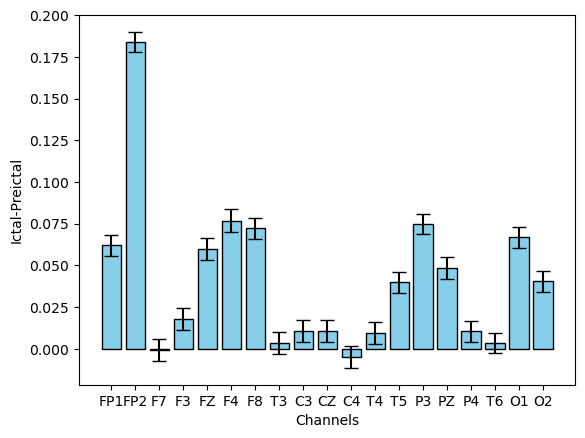

In [397]:
# 
categories = electrodes
means = np.mean(Gamma_mat, axis=0)
std_devs = np.std(Gamma_mat, axis=0)/np.sqrt(Gamma_mat.shape[0])

# Bar plot
x_positions = np.arange(len(categories))  # X-axis positions
plt.bar(x_positions, means, yerr=std_devs, capsize=5, color='skyblue', edgecolor='black')

# Labels and title
plt.xticks(x_positions, categories)
plt.xlabel('Channels')
plt.ylabel('Ictal-Preictal')
# Display the plot
plt.show()

In [401]:
from scipy.stats import f_oneway

# Perform ANOVA across rows
stat, p_value = f_oneway(*Gamma_mat)
print(f"ANOVA Statistic: {stat:.3f}, p-value: {p_value:.3e}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the rows.")
else:
    print("There is no significant difference between the rows.")


ANOVA Statistic: 11.509, p-value: 0.000e+00
There is a significant difference between the rows.


In [405]:
# Statistical test ! :)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# matrix = Gamma_mat
# #  Prepare data for Tukey test
# data = matrix.flatten()  # Flatten the matrix into a single array
# groups = np.array([[f"Group {i+1}"] * matrix.shape[1] for i in range(matrix.shape[0])]).flatten()

# # Perform Tukey's HSD test
# tukey_results = pairwise_tukeyhsd(endog=data, groups=groups, alpha=0.05)

# # Display results
# print(tukey_results)
# tukey_results.plot_simultaneous()  # Optional: Plot confidence intervals

In [ ]:
# Plot Centrality in time for all seizures

# for file_num in nFOZ.keys():
#     ROIs = nFOZ[file_num]
#     ROI_list = list(ROIs.values())
#     FOZ_time = list(ROIs.keys())

#     for seiz_num in range(len(ROI_list)):
#         start_point = int(FOZ_time[seiz_num])
#         plt.imshow((np.array(CentralityElectrodes[file_num][seiz_num])).T, cmap='spring', aspect='auto')
#         plt.colorbar(label='Value')
#         plt.xlabel('Time(sec)')
#         # plt.ylabel('Electrode#')
#         plt.yticks(ticks=np.arange(len(electrodes)), labels=electrodes)
#         selected_indices = [electrodes.index(el) for el in ROI_list[seiz_num]]
#         for idx in selected_indices:
#              plt.axhline(y=idx, color='b', linestyle='--', linewidth=2)
#         plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
#         plt.title(f'File {file_num+1}, Seiz {seiz_num+1}')
#         plt.show()

In [ ]:
# Plot density in time for all seizures

# for file_num in nFOZ.keys():
#     ROIs = nFOZ[file_num]
#     ROI_list = list(ROIs.values())
#     FOZ_time = list(ROIs.keys())

#     for seiz_num in range(len(ROI_list)):
#         start_point = int(FOZ_time[seiz_num])
#         plt.plot(moving_average(np.array(Densities[file_num][seiz_num]),20))
#         plt.xlabel('Time(sec)')
#         plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
#         plt.title(f'File {file_num+1}, Seiz {seiz_num+1}')
#         plt.show()

In [ ]:
# 1 !
CentAtTime = np.array(CentralityElectrodes[file_num][seiz_num])
print(CentAtTime[start_point])
print(start_point)

# plt.plot(CentAtTime[start_point+100])
plt.plot(CentAtTime[718])
plt.plot(CentAtTime[585])
plt.plot(CentAtTime[200])

print(int(np.array(np.where(Densities[file_num][seiz_num] == np.max(Densities[file_num][seiz_num])))))
print(int(np.array(np.where(Densities[file_num][seiz_num] == np.min(Densities[file_num][seiz_num])))))
np.max(CentAtTime[718])-np.min(CentAtTime[718])
np.mean(CentAtTime[718])-np.mean(CentAtTime[585])
np.max(CentAtTime[508])-np.min(CentAtTime[508])


[0.31003206 0.49790347 0.42916089 0.524242   0.37624336 0.39169528
 0.61939935 0.43211245 0.55711741 0.54418289 0.52693969 0.57975511
 0.46174418 0.62866281 0.56689179 0.4743332  0.36804412 0.51193421
 0.38917916]
685


In [67]:
def clusters_spectral(graph, n_clusters):
    """
    Find communities in a graph using Spectral Clustering.

    Args:
        graph (nx.Graph): The input NetworkX graph.
        n_clusters (int): The number of clusters to identify.

    Returns:
        dict: A dictionary mapping community IDs to lists of node members.
    """
    # Check if the graph has edges
    if graph.number_of_edges() > 0:
        # Convert the graph to an adjacency matrix
        adjacency_matrix = nx.to_numpy_array(graph)
        
        # Perform Spectral Clustering
        sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
        labels = sc.fit_predict(adjacency_matrix)
        
        # Extract communities and their members
        communities = {}
        for node, community_id in zip(graph.nodes(), labels):
            if community_id not in communities:
                communities[community_id] = []
            communities[community_id].append(node)
    else:
        communities = {}
        print("No edges in the graph, no communities found.")

    return communities

c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are 

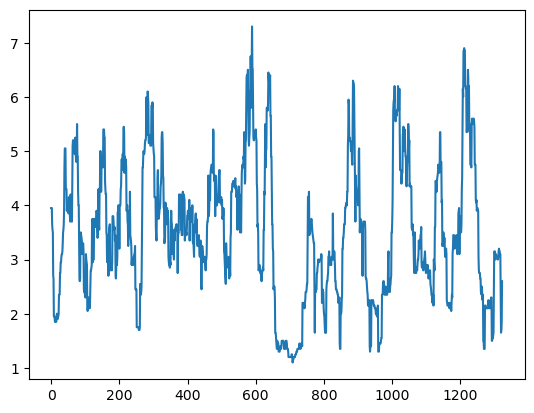

In [68]:
# Initialize storage for results
Components = {}
eegICA = all_data[file_num]['eegICA']  # Preprocessed EEG data
plv_bi = all_data[file_num]['plv_bi']  # Phase Locking Value 
graphs = all_data[file_num]['graphs']  # Graphs for the current file
graphs_bi = all_data[file_num]['graphs_bi']  # Binary graphs for the current file
oke = []  # List to store the estimated number of clusters for each graph

# Process each binary graph to estimate the number of clusters
for G in graphs_bi:
    # Compute the normalized Laplacian matrix
    laplacian = nx.normalized_laplacian_matrix(G).toarray()
    
    # Compute and sort eigenvalues of the Laplacian
    eigenvalues = np.sort(np.linalg.eigvals(laplacian))
    
    # Estimate the number of clusters based on the largest spectral gap
    gaps = np.diff(eigenvalues)
    optimal_k = np.argmax(gaps) + 1
    oke.append(optimal_k)

# Visualize the estimated number of clusters using a moving average
plt.plot(moving_average(oke, 20))

# Perform spectral clustering for each graph using the estimated cluster count
communities_s = [clusters_spectral(graphs_bi[i], oke[i]) for i in range(len(graphs_bi))]

# Save the results for the current file
Components[file_num] = {
    'Communities': communities_s,  # Detected communities for each graph
    'Num_Comp': oke}  # List of estimated number of clusters


Text(0.5, 1.0, 'File aaaaaalq_s001_t000, Seiz 1')

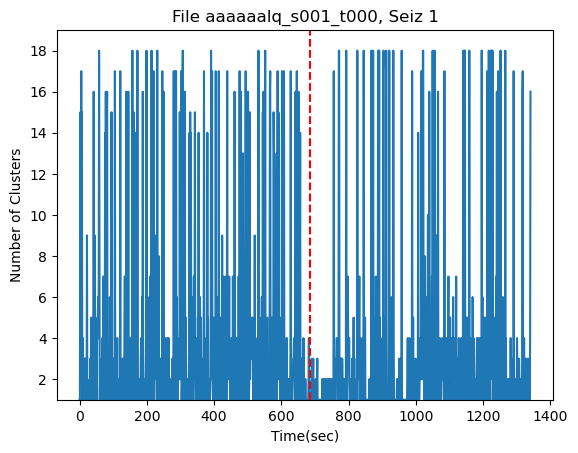

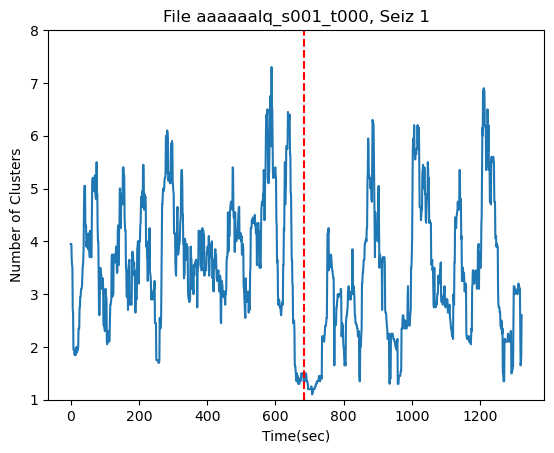

In [82]:
# Visualize the estimated number of clusters using a moving average
plt.figure()
plt.plot(oke)
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Number of Clusters')
plt.ylim(1, 19)
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')

plt.figure()
plt.plot(moving_average(oke, 20))
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Number of Clusters')
plt.ylim(1, 8)
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')

In [ ]:
# Define colors and locations for plotting clusters
colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ff5733',  # Bright Orange
    '#33ff57',  # Lime Green
    '#5733ff',  # Violet
    '#ff33a8',  # Hot Pink
    '#a8ff33',  # Neon Green
    '#33a8ff',  # Sky Blue
    '#ff3380',  # Raspberry
    '#80ff33',  # Bright Lime
    '#3380ff',  # Royal Blue
    '#ffdf33'   # Gold
]

# Electrode locations
electrode_locations = {
    'EEG FP1-LE': [-0.3, 0.8],
    'EEG FP2-LE': [0.3, 0.8],
    'EEG F7-LE': [-0.7, 0.5],
    'EEG F3-LE': [-0.4, 0.4],
    'EEG FZ-LE': [0.0, 0.3],
    'EEG F4-LE': [0.4, 0.4],
    'EEG F8-LE': [0.7, 0.5],
    'EEG T3-LE': [-0.8, 0.0],
    'EEG C3-LE': [-0.5, 0.0],
    'EEG CZ-LE': [0.0, 0.0],
    'EEG C4-LE': [0.5, 0.0],
    'EEG T4-LE': [0.8, 0.0],
    'EEG T5-LE': [-0.6, -0.5],
    'EEG P3-LE': [-0.4, -0.4],
    'EEG PZ-LE': [0.0, -0.3],
    'EEG P4-LE': [0.4, -0.4],
    'EEG T6-LE': [0.6, -0.5],
    'EEG O1-LE': [-0.3, -0.8],
    'EEG O2-LE': [0.3, -0.8]
}

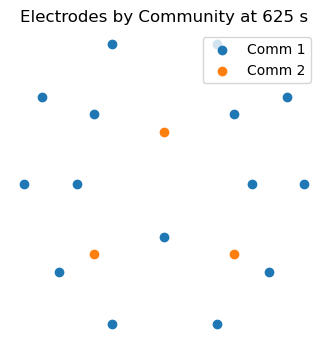

In [156]:
# Plot clusters before seizure onset
A = 0 # duration considered after seizure onset
B = 59 # duration considered  prior to seizure onset
d = 1 # duration considered for seizure

# Communities
# for sec in range(start_point-B-d, start_point+A+d):
for sec in range(start_point-B-d, start_point-B):
# for sec in range(start_point-B-d, start_point+A+d):
    # Dynamically assign colors using a colormap
    num_groups = len(communities_s[sec])

    # Plot the locations
    plt.figure(figsize=(4, 4))
    for group_id, selectrodes in communities_s[sec].items():
        color = colors[group_id]  # Get color for the group
        for electrode in selectrodes:
            coords = electrode_locations[electrode]
            plt.scatter(coords[0], coords[1], color=color, label=f'Comm {group_id+1}' if electrode == selectrodes[0] else '')  # Plot each electrode
            # plt.text(coords[0], coords[1] + 0.02, electrode, fontsize=8, ha='center')  # Add labels

    # Formatting the plot
    plt.title(f'Electrodes by Community at {sec} s', fontsize=12)
    plt.axis('off')  # Remove the axis
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal

    # Add legend
    plt.legend(loc='upper right')
    plt.show()

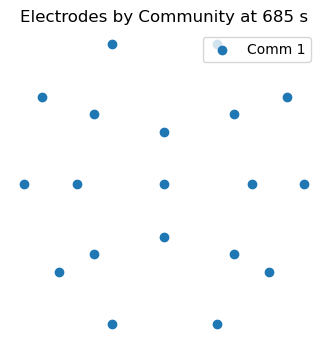

In [89]:
# Communities
# for sec in range(start_point-B-d, start_point+A+d):
for sec in range(start_point+A, start_point+A+d):
    # Dynamically assign colors using a colormap
    num_groups = len(communities_s[sec])

    # Plot the locations
    plt.figure(figsize=(4, 4))
    for group_id, selectrodes in communities_s[sec].items():
        color = colors[group_id]  # Get color for the group
        for electrode in selectrodes:
            coords = electrode_locations[electrode]
            plt.scatter(coords[0], coords[1], color=color, label=f'Comm {group_id+1}' if electrode == selectrodes[0] else '')  # Plot each electrode
            # plt.text(coords[0], coords[1] + 0.02, electrode, fontsize=8, ha='center')  # Add labels

    # Formatting the plot
    plt.title(f'Electrodes by Community at {sec} s', fontsize=12)
    plt.axis('off')  # Remove the axis
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal

    # Add legend
    plt.legend(loc='upper right')
    plt.show()

Text(0, 0.5, 'Overlap Ratio')

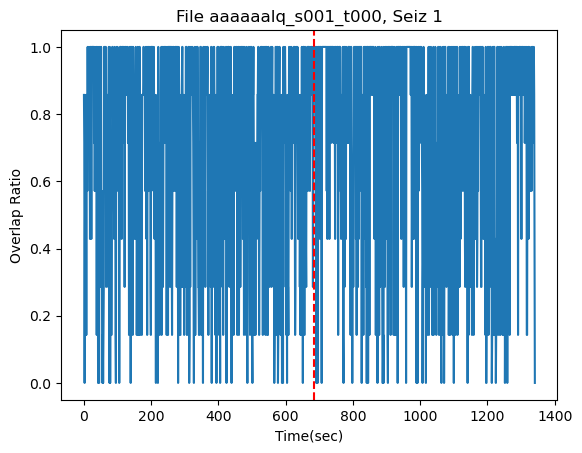

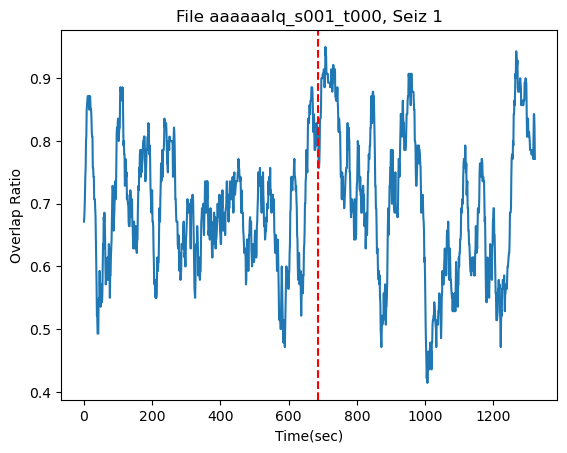

In [ ]:
# Calculate and plot the overlap between hub cluster and focal zone respect to focal zone
OL_R = {}

OL_R[file_num] = {}
communities_s = Components[file_num]['Communities'] 
graphs_bi = all_data[file_num]['graphs_bi']
ROIs = nFOZ[file_num]
ROI_list = list(ROIs.values())
FOZ_time = list(ROIs.keys())

roi = ROI_list[seiz_num]

overlap_ratio = []
OverlapNodes = []
hub_cluster = []
for i in range(len(graphs_bi)):    
    centrality_s = nx.eigenvector_centrality(graphs_bi[i], max_iter= 1000)
    average_centrality = {hub_m: np.mean([centrality_s[node] for node in cluster]) for hub_m, cluster in communities_s[i].items()}
    hub_cluster.append(max(average_centrality, key=average_centrality.get))
    hub_clusters = max(average_centrality, key=average_centrality.get)
    # Quantify overlap
    hub_nodes = communities_s[i][hub_clusters]
    hub_nodes = [item.replace('EEG', '').replace('-LE', '').replace(' ', '')  for item in hub_nodes]
    overlap_nodes = set(roi).intersection(hub_nodes)
    OverlapNodes.append(overlap_nodes)
    overlap_ratio.append(len(overlap_nodes) / len(roi))

OL_R[file_num][seiz_num] = overlap_ratio

plt.figure()
plt.plot(overlap_ratio) 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Overlap Ratio')

plt.figure()
plt.plot(moving_average(overlap_ratio, 20)) 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Overlap Ratio')

Text(0, 0.5, 'Overlap Ratio')

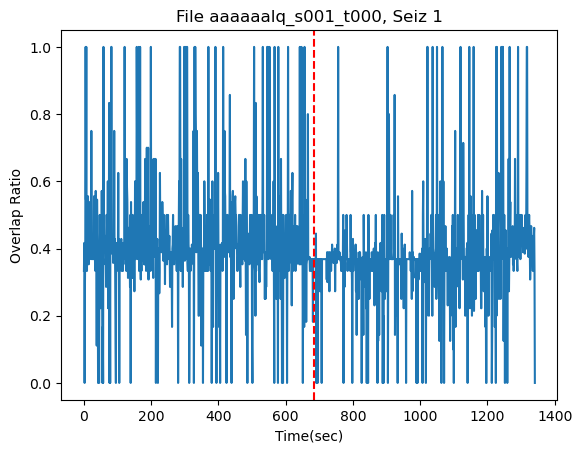

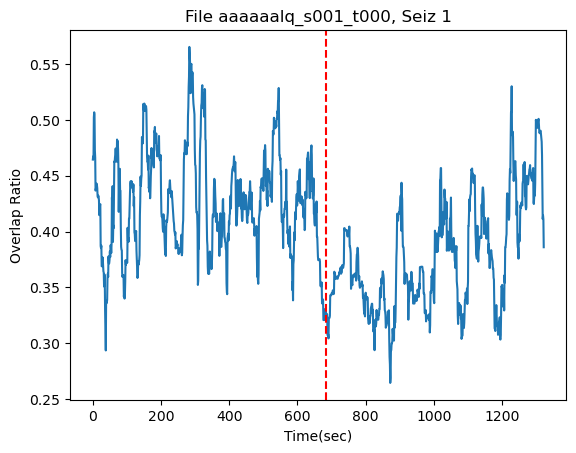

In [ ]:
# Calculate and plot the overlap between hub cluster and focal zone respect to hub cluster
OL_R = {}

OL_R[file_num] = {}
communities_s = Components[file_num]['Communities'] 
graphs_bi = all_data[file_num]['graphs_bi']
ROIs = nFOZ[file_num]
ROI_list = list(ROIs.values())
FOZ_time = list(ROIs.keys())

roi = ROI_list[seiz_num]

overlap_ratio = []
OverlapNodes = []
hub_cluster = []
for i in range(len(graphs_bi)):    
    centrality_s = nx.eigenvector_centrality(graphs_bi[i], max_iter= 1000)
    average_centrality = {hub_m: np.mean([centrality_s[node] for node in cluster]) for hub_m, cluster in communities_s[i].items()}
    hub_cluster.append(max(average_centrality, key=average_centrality.get))
    hub_clusters = max(average_centrality, key=average_centrality.get)
    # Quantify overlap
    hub_nodes = communities_s[i][hub_clusters]
    hub_nodes = [item.replace('EEG', '').replace('-LE', '').replace(' ', '')  for item in hub_nodes]
    overlap_nodes = set(roi).intersection(hub_nodes)
    OverlapNodes.append(overlap_nodes)
    # overlap_ratio.append(len(overlap_nodes) / len(roi))
    overlap_ratio.append(len(overlap_nodes) / len(hub_nodes))

OL_R[file_num][seiz_num] = overlap_ratio

plt.figure()
plt.plot(overlap_ratio) 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Overlap Ratio')

plt.figure()
plt.plot(moving_average(overlap_ratio, 20)) 
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.xlabel('Time(sec)')
plt.axvline(x=start_point, color='red', linestyle='--', label='Seizure Start') 
plt.ylabel('Overlap Ratio')

In [ ]:
# 2 !
np.mean(overlap_ratio[:start_point])/np.mean(overlap_ratio[start_point+20:])

0.9785428916464426

c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


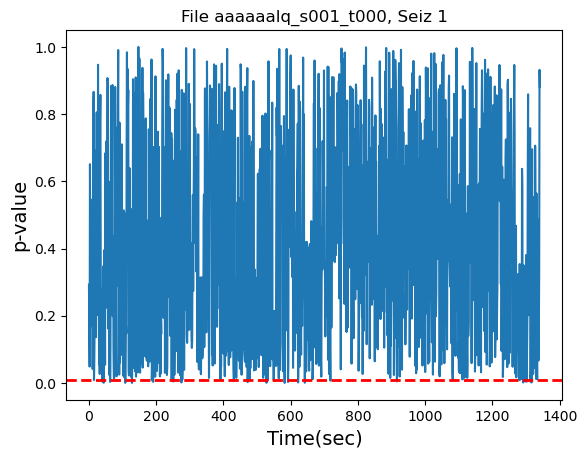

In [404]:
from scipy.stats import ttest_ind

file_num = 57
seiz_num = 0

communities_s = Components[file_num]['Communities'] 
graphs_bi = all_data[file_num]['graphs_bi']
ROIs = nFOZ[file_num]
ROI_list = list(ROIs.values())
FOZ_time = list(ROIs.keys())
roi = ROI_list[seiz_num]
fc = []
nfc = []
test_result = []
pvalue = []

for i in range(len(graphs_bi)):    
    centrality_s = nx.eigenvector_centrality(graphs_bi[i], max_iter= 1000)
    c_centrality_s = {key.replace('-REF', '').replace('-LE', '').replace('EEG ', ''): value for key, value in centrality_s.items()}
    order = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']

    c_centrality_sn = sort_dict_by_list_order(c_centrality_s, order)
    focal_centrality = [c_centrality_sn[node] for node in roi]
    # fc.append(focal_centrality)
    nonfocal_centrality = [c_centrality_sn[node] for node in list(set(electrodes)-set(roi))]
    # nfc.append(nonfocal_centrality)
    t_stat, p_val = ttest_ind(focal_centrality, nonfocal_centrality, equal_var=False)

    test_result.append(t_stat)
    pvalue.append(p_val)

plt.plot(pvalue)
plt.axhline(y=0.01, color='r', linestyle='--', linewidth=2)
plt.xlabel('Time(sec)', fontsize= 14)
plt.ylabel('p-value', fontsize= 14)
# plt.title('Statistical Test Result')
plt.title(f'File {RecNam[file_num][:18]}, Seiz {seiz_num+1}')
plt.show()
